# [DACON] 손동작 분류 경진대회

## 풀이방법
* 저는 머신러닝 LightGBM 모델로 돌리다가기세현님의 CNN 아이디어가 좋고 성능도 좋아서 베이스코드로 사용하게 되었습니다. >> LightGBM 썼을때 0.83점 정도가 나옴

1. 이상치가 많아서 이상치를 조정해 주기 위해 RobustScaler를 사용하게 되었습니다.
2. 기존 CNN 코드에서 층 수를 줄였습니다.
3. 활성화함수는 Relu로 설정하고, Maxpooling을 제거하고, Flatten을  추가해주었습니다. >> cnn size가 너무 작아서 MaxPooling을 제거
4. learing_rate에 영향이 큰다는 것을 발견하여서 0.004가 제일 성능이 좋아서 조절해주었습니다.
5. 층수를 늘린 DCNN, LSTM, GRU도 사용하여 성능을 비교해보았습니다. >> 센서 데이터를 시계열로 고려해서 LSTM을 썼더니 CNN과 비슷한 성능을 가지긴 하였습니다.
6. 과반수 원리를 이용한 Voting을 사용해보았습니다 >> sklearn 라이브러리를 안쓰고 따로 과반수원리 코드를 짜서 사용했습니다.

* 또 다른 중요한 결론 : Keras 짱

# 1. 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install tensorflow

In [ ]:
#라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization,MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dropout

In [ ]:
import warnings
warnings.filterwarnings("ignore")

path = '/content/drive/MyDrive/모의, 실전경진대회/[DACON] 손동작 분류 경진대회/data/'

train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')
train.head()

,id,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,target
0,1,-6.149463,-0.929714,9.058368,-7.017854,-2.958471,0.179233,-0.956591,-0.972401,5.956213,...,-7.026436,-6.006282,-6.005836,7.043084,21.884650,-3.064152,-5.247552,-6.026107,-11.990822,1
1,2,-2.238836,-1.003511,5.098079,-10.880357,-0.804562,-2.992123,26.972724,-8.900861,-5.968298,...,-1.996714,-7.933806,-3.136773,8.774211,10.944759,9.858186,-0.969241,-3.935553,-15.892421,1
2,3,19.087934,-2.092514,0.946750,-21.831788,9.119235,17.853587,-21.069954,-15.933212,-9.016039,...,-6.889685,54.052330,-6.109238,12.154595,6.095989,-40.195088,-3.958124,-8.079537,-5.160090,0
3,4,-2.211629,-1.930904,21.888406,-3.067560,-0.240634,2.985056,-29.073369,0.200774,-1.043742,...,-2.126170,-1.035526,2.178769,10.032723,-1.010897,-3.912848,-2.980338,-12.983597,-3.001077,1
4,5,3.953852,2.964892,-36.044802,0.899838,26.930210,11.004409,-21.962423,-11.950189,-20.933785,...,-2.051761,10.917567,1.905335,-13.004707,17.169552,2.105194,3.967986,11.861657,-27.088846,2


# 2 EDA

In [ ]:
#train과 test의 개수
print(train.shape)
print(test.shape)

(2335, 34)
(9343, 33)


In [ ]:
#결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 34 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2335 non-null   int64  
 1   sensor_1   2335 non-null   float64
 2   sensor_2   2335 non-null   float64
 3   sensor_3   2335 non-null   float64
 4   sensor_4   2335 non-null   float64
 5   sensor_5   2335 non-null   float64
 6   sensor_6   2335 non-null   float64
 7   sensor_7   2335 non-null   float64
 8   sensor_8   2335 non-null   float64
 9   sensor_9   2335 non-null   float64
 10  sensor_10  2335 non-null   float64
 11  sensor_11  2335 non-null   float64
 12  sensor_12  2335 non-null   float64
 13  sensor_13  2335 non-null   float64
 14  sensor_14  2335 non-null   float64
 15  sensor_15  2335 non-null   float64
 16  sensor_16  2335 non-null   float64
 17  sensor_17  2335 non-null   float64
 18  sensor_18  2335 non-null   float64
 19  sensor_19  2335 non-null   float64
 20  sensor_2

In [ ]:
#train 데이터의 target 분포
train['target'].value_counts()

3    599
2    593
1    574
0    569
Name: target, dtype: int64

##이상치 확인

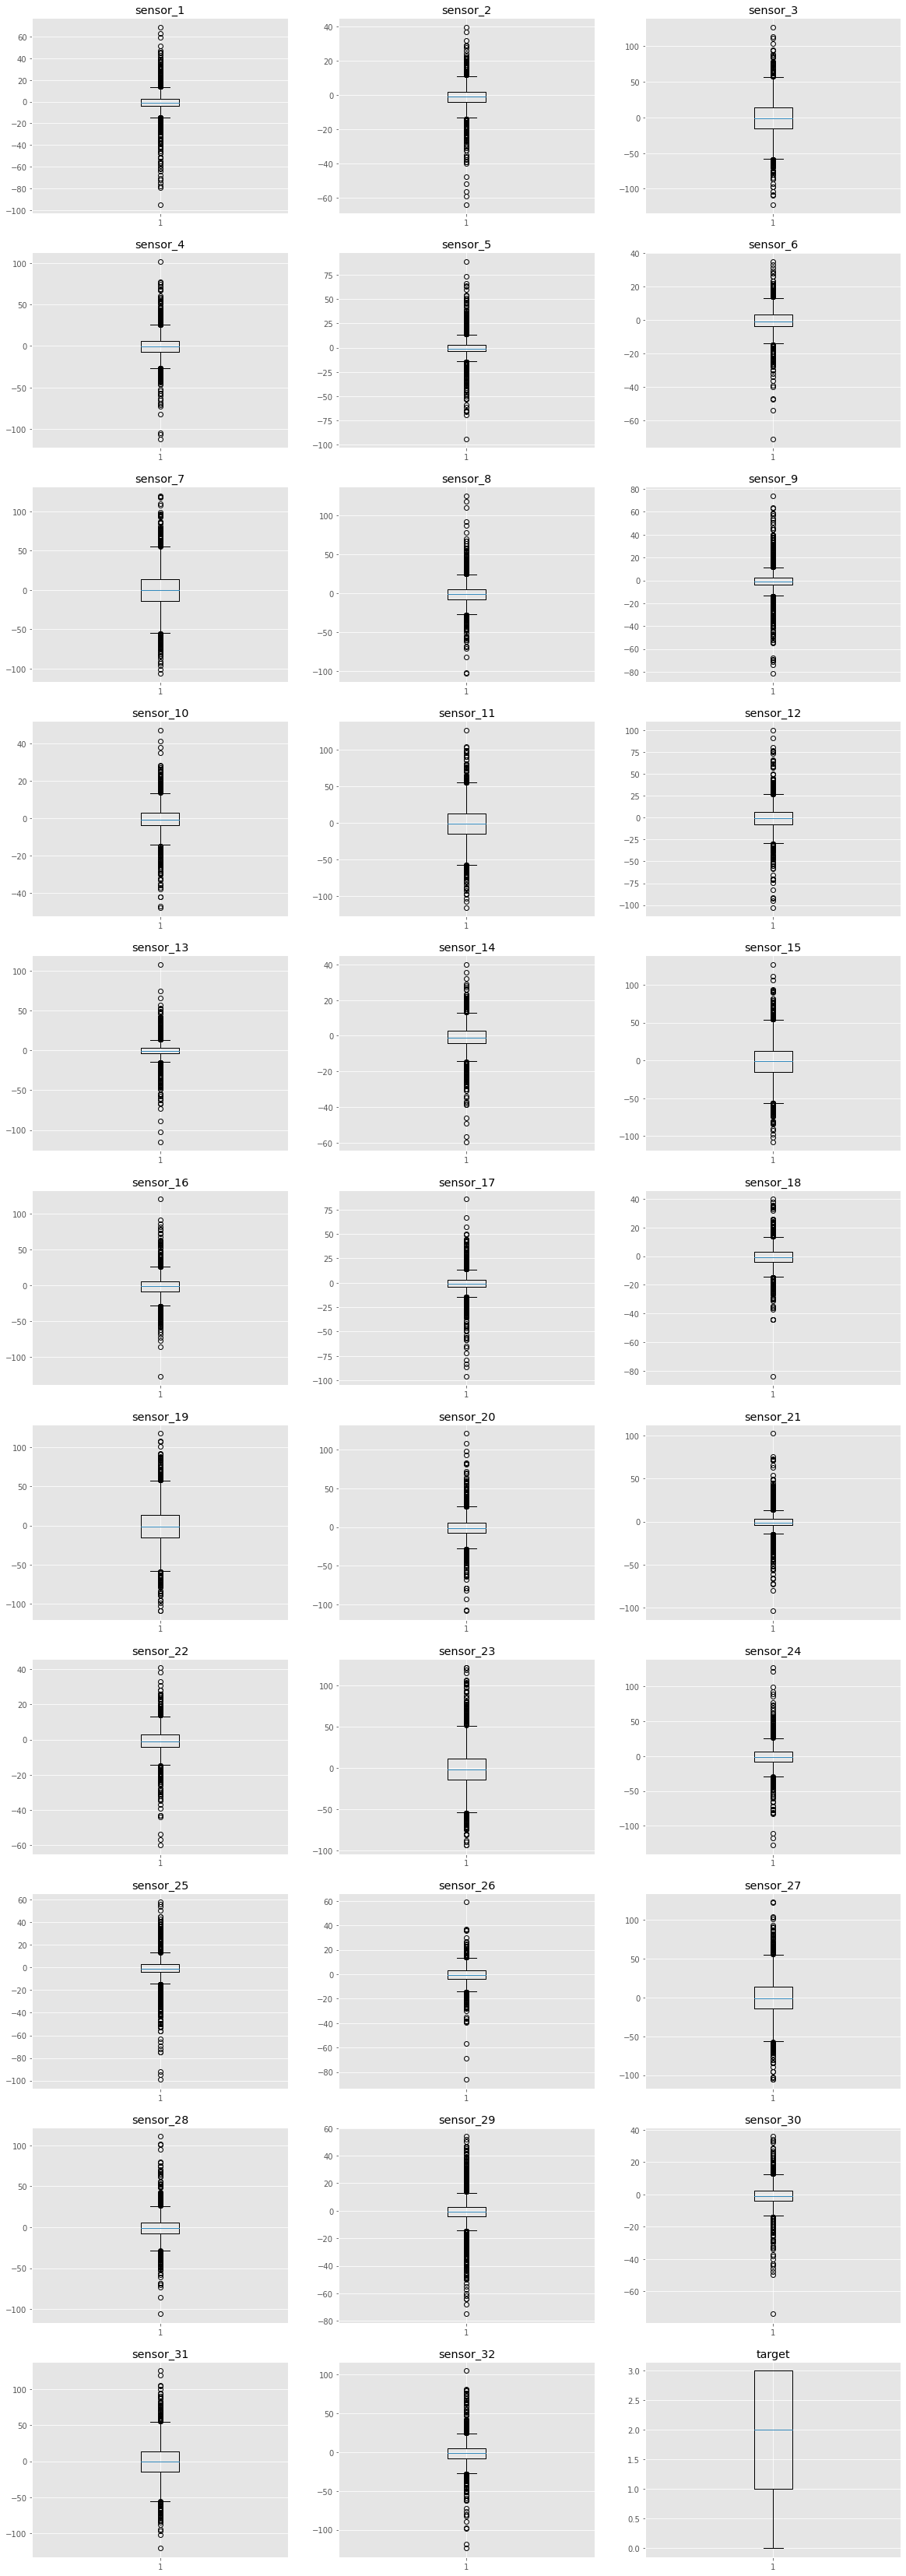

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

#Id컬럼은 제거
feature = train.columns[1:]
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.boxplot(train[feature[i]])
plt.show()

target 별 특징을 생각해보던 중 Image 변환을 시도해 보았습니다. groupby 후 센서마다 mean 값(32개 센서)을 8 by 4 이미지로 변환해서 살펴봤습니다.

In [ ]:
gr_mu = train.groupby('target').mean().iloc[:, 1:]
gr_mu

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,...,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32
target,,,,,,,,,,,,,,,,,,,,,
0,-0.425433,-0.922978,1.389976,0.559473,-0.694207,0.015784,0.793226,-0.913523,-0.561867,-0.802052,...,0.022476,-0.056393,-1.587852,-0.420015,0.905688,0.151944,-0.626062,-0.822711,-0.621473,-1.962038
1,-0.692796,-0.776260,-1.040046,-0.796645,-0.716867,-0.864049,0.217547,-0.588134,-0.795507,-0.470282,...,-0.727154,-0.841780,-0.605011,-0.622476,0.257340,-0.515845,-0.883002,-0.682358,0.154507,-0.607232
2,-2.346430,-0.822219,1.015480,0.079543,0.805130,-0.322211,-1.559588,-1.354339,-1.188115,-1.084991,...,0.926393,-0.561614,-0.598858,-0.591853,-2.619469,-0.660750,-0.706551,-0.714254,-0.997320,-0.504212
3,-0.983485,-1.559744,-3.951593,-0.422654,-0.727304,-0.518749,3.218229,-0.876624,-0.636275,-0.459929,...,-0.134662,0.026740,-0.935549,-0.714854,1.169092,-0.441372,-0.693405,-1.013212,-0.500214,0.046207


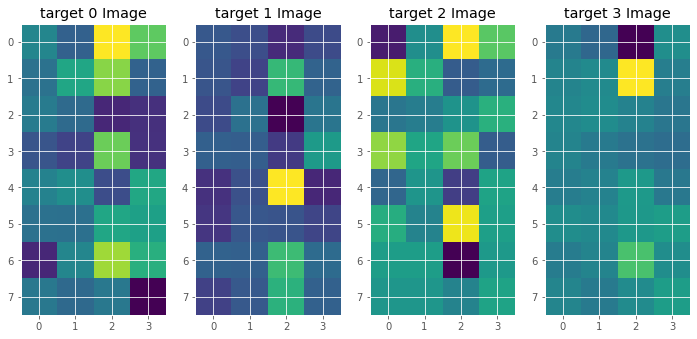

In [ ]:
f, a = plt.subplots(1, 4, figsize = (12, 6))
for i in range(4) :
    a[i].set_title(f'target {i} Image')
    a[i].imshow(np.array(gr_mu.iloc[i]).reshape(8, 4))

비록 통계량을 통해 봤지만 target별로 어느 정도 다른 형태를 띈다고 볼 수 있을 것 같습니다.

## 데이터 분리 및 정규화

1. 학습 데이터에서 target 데이터를 분리합니다.
2. 이상치 처리를 위해 **RobustScaler 사용**

In [ ]:
X = train.iloc[:, 1:-1]
target = test.iloc[:, 1:]

In [ ]:
#scaleing
from sklearn.preprocessing import RobustScaler
sc= RobustScaler()
X = sc.fit_transform(X)
target = sc.fit_transform(target)

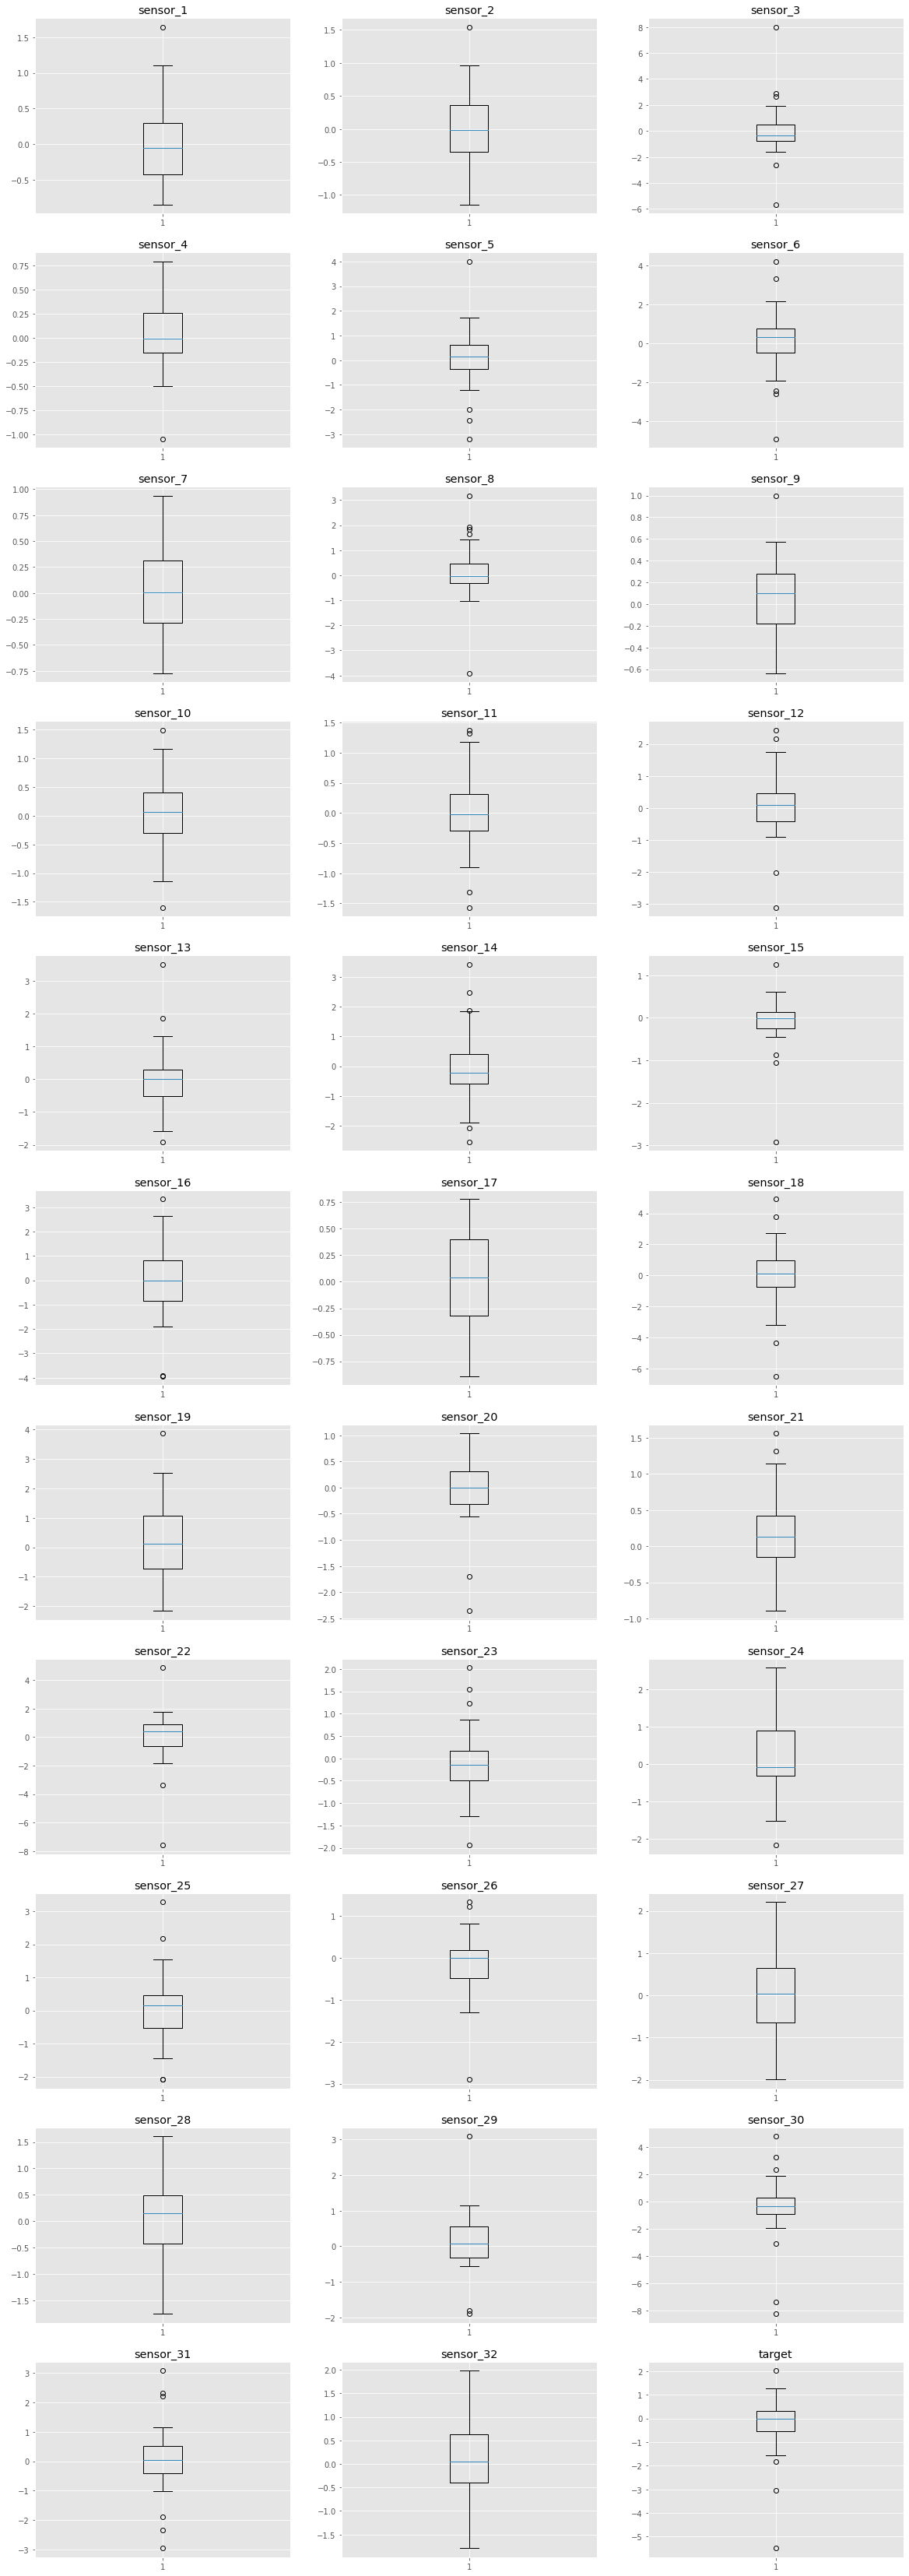

In [ ]:
#이상치 다시 확인
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

#Id컬럼은 제거
feature = train.columns[1:]
# Boxplot 을 사용해서 데이터의 분포를 살펴봅니다.
plt.figure(figsize=(20,60))

for i in range(len(feature)):
    plt.subplot(11,3,i+1)
    plt.title(feature[i])
    plt.boxplot(X[i])
plt.show()

In [ ]:
# def outliers_iqr(data):
#     q1, q3 = np.percentile(data, [25, 75])
#     # 넘파이의 값을 퍼센트로 표시해주는 함수

#     iqr = q3 - q1
#     lower_bound = q1 - (iqr * 1.5)
#     upper_bound = q3 + (iqr * 1.5)
    
#     return np.where((data > upper_bound) | (data < lower_bound))

sensor1 ~ 32이기 때문에 8 * 4형태로 바꾸어줍니다.

In [ ]:
X = np.array(X).reshape(-1, 8, 4, 1)
target = np.array(target).reshape(-1, 8, 4, 1)

In [ ]:
X.shape

(2335, 8, 4, 1)

In [ ]:
target.shape

(9343, 8, 4, 1)

MultiClass를 위해 target 값에 One-Hot 인코딩을 취해줍니다.

In [ ]:
#원-핫인코딩
ohe = OneHotEncoder(sparse = False)
y = ohe.fit_transform(train[['target']])

In [ ]:
# k-fold
skf = StratifiedKFold(n_splits = 15, random_state = 42, shuffle = True)

In [ ]:
#Early stopping
es = EarlyStopping(monitor = 'val_acc', patience = 5, mode = 'max', verbose = 0)

#CNN

In [ ]:
from sklearn.utils import shuffle

cnn_acc = []
cnn_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn = Sequential()
    cnn.add(Conv2D(32, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(16, (1, 1), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(32, (4, 4), padding = "same", activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(GlobalAveragePooling2D())
    cnn.add(Flatten())
    cnn.add(Dense(32, activation = 'relu'))
    # cnn.add(Dropout(0.25))
    cnn.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    cnn.compile(optimizer = Adam(learning_rate = 0.004), loss = 'categorical_crossentropy', metrics = ['acc'])

    cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    cnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of CNN = 0.8717948717948718

2 Fold Training.....
2 Fold ACC of CNN = 0.8846153846153846

3 Fold Training.....
3 Fold ACC of CNN = 0.8974358974358975

4 Fold Training.....
4 Fold ACC of CNN = 0.9038461538461539

5 Fold Training.....
5 Fold ACC of CNN = 0.9487179487179487

6 Fold Training.....
6 Fold ACC of CNN = 0.8782051282051282

7 Fold Training.....
7 Fold ACC of CNN = 0.8910256410256411

8 Fold Training.....
8 Fold ACC of CNN = 0.8846153846153846

9 Fold Training.....
9 Fold ACC of CNN = 0.8974358974358975

10 Fold Training.....
10 Fold ACC of CNN = 0.9038461538461539

11 Fold Training.....
11 Fold ACC of CNN = 0.8774193548387097

12 Fold Training.....
12 Fold ACC of CNN = 0.8580645161290322

13 Fold Training.....
13 Fold ACC of CNN = 0.864516129032258

14 Fold Training.....
14 Fold ACC of CNN = 0.8838709677419355

15 Fold Training.....
15 Fold ACC of CNN = 0.9290322580645162



In [ ]:
cnn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 8, 4, 32)          160       
                                                                 
 batch_normalization_42 (Bat  (None, 8, 4, 32)         128       
 chNormalization)                                                
                                                                 
 conv2d_43 (Conv2D)          (None, 8, 4, 16)          528       
                                                                 
 batch_normalization_43 (Bat  (None, 8, 4, 16)         64        
 chNormalization)                                                
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 4, 32)          8224      
                                                                 
 batch_normalization_44 (Bat  (None, 8, 4, 32)       

In [ ]:
np.mean(cnn_acc)

0.8916294458229942

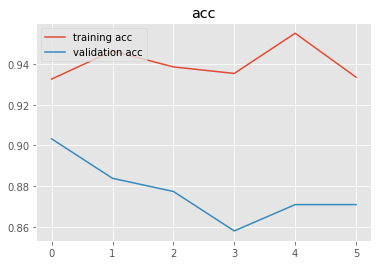

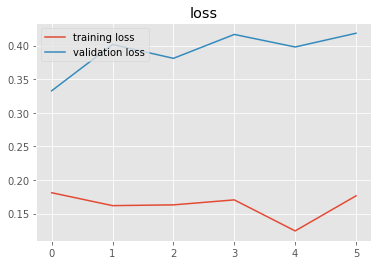

In [ ]:
#acc
history = cnn.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training acc', 'validation acc'], loc = 'upper left')
plt.title("acc")
plt.show()

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper left')
plt.title("loss")
plt.show()

## DCNN

In [ ]:
cnn_acc2 = []
cnn_pred2 = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### CNN 모델
    cnn2 = Sequential()
    cnn2.add(Conv2D(64, (2, 2), padding = "same", activation = 'relu', input_shape = (8, 4, 1)))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv2D(16, (1, 1), padding = "same", activation = 'relu', input_shape = (8, 4, 1)))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv2D(64, (3, 3), padding = "same", activation = 'relu'))
    # cnn.add(MaxPooling2D(2, 2))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv2D(16, (1, 1), padding = "same", activation = 'relu'))
    cnn2.add(BatchNormalization())
    cnn2.add(Conv2D(64, (4, 4), padding = "same", activation = 'relu'))
    cnn2.add(BatchNormalization())
    cnn2.add(GlobalAveragePooling2D())
    cnn2.add(Dense(32, activation = 'relu'))
    cnn2.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    cnn2.compile(optimizer = Adam(learning_rate = 0.004), loss = 'categorical_crossentropy', metrics = ['acc'])

    cnn2.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 200, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    cnn_acc2.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of CNN = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred2 = best.predict(target) / skf.n_splits
    cnn_pred2 += fold_pred2

1 Fold Training.....
1 Fold ACC of CNN = 0.8675213675213675

2 Fold Training.....
2 Fold ACC of CNN = 0.8632478632478633

3 Fold Training.....
3 Fold ACC of CNN = 0.8846153846153846

4 Fold Training.....
4 Fold ACC of CNN = 0.905982905982906

5 Fold Training.....
5 Fold ACC of CNN = 0.8974358974358975

6 Fold Training.....
6 Fold ACC of CNN = 0.871244635193133

7 Fold Training.....
7 Fold ACC of CNN = 0.8969957081545065

8 Fold Training.....
8 Fold ACC of CNN = 0.871244635193133

9 Fold Training.....
9 Fold ACC of CNN = 0.8669527896995708

10 Fold Training.....
10 Fold ACC of CNN = 0.8927038626609443



In [ ]:
np.mean(cnn_acc2)

0.8817945049704706

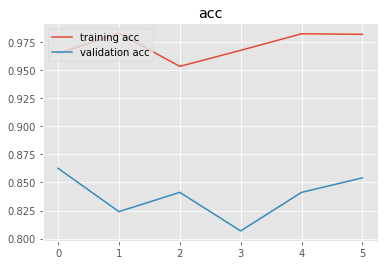

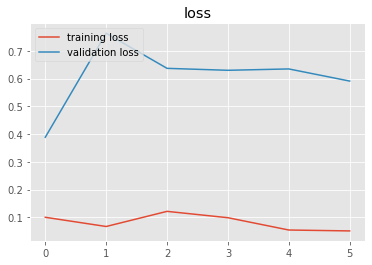

In [ ]:
#acc
history2 = cnn2.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 200, batch_size = 32, callbacks = [es, mc], verbose = 0)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['training acc', 'validation acc'], loc = 'upper left')
plt.title("acc")
plt.show()

#loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper left')
plt.title("loss")
plt.show()

## LSTM

In [ ]:
from keras.layers import SimpleRNN
rnn_acc = []
rnn_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### RNN 모델
    lstm = Sequential()
    lstm.add(LSTM(32, input_shape = (8,4), return_sequences = True))
    # lstm.add(LSTM(32, return_sequences = True))
    lstm.add(LSTM(32, return_sequences = False))
    lstm.add(Flatten())
    # lstm.add(Dense(32, activation = 'relu'))
    lstm.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    lstm.compile(optimizer = Adam(learning_rate = 0.004), loss = 'mean_squared_error', metrics = ['acc'])

    lstm.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    rnn_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of LSTM = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / 15
    rnn_pred += fold_pred

1 Fold Training.....
1 Fold ACC of LSTM = 0.8846153846153846

2 Fold Training.....
2 Fold ACC of LSTM = 0.8974358974358975

3 Fold Training.....
3 Fold ACC of LSTM = 0.8846153846153846

4 Fold Training.....
4 Fold ACC of LSTM = 0.9230769230769231

5 Fold Training.....
5 Fold ACC of LSTM = 0.9551282051282052

6 Fold Training.....
6 Fold ACC of LSTM = 0.8910256410256411

7 Fold Training.....
7 Fold ACC of LSTM = 0.9166666666666666

8 Fold Training.....
8 Fold ACC of LSTM = 0.8525641025641025

9 Fold Training.....
9 Fold ACC of LSTM = 0.8846153846153846

10 Fold Training.....
10 Fold ACC of LSTM = 0.9102564102564102

11 Fold Training.....
11 Fold ACC of LSTM = 0.8580645161290322

12 Fold Training.....
12 Fold ACC of LSTM = 0.8709677419354839

13 Fold Training.....
13 Fold ACC of LSTM = 0.8774193548387097

14 Fold Training.....
14 Fold ACC of LSTM = 0.8903225806451613

15 Fold Training.....
15 Fold ACC of LSTM = 0.9290322580645162



In [ ]:
np.mean(rnn_acc)

0.8950537634408602

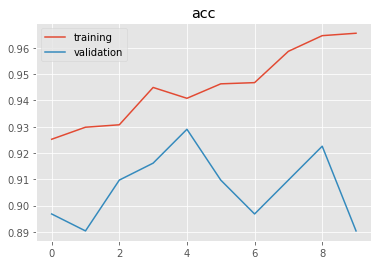

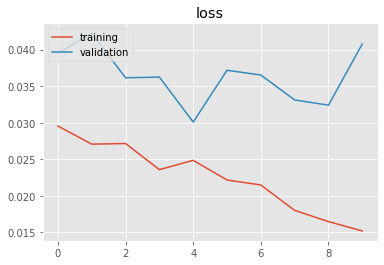

In [ ]:
#acc
history2 = lstm.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title("acc")
plt.show()

#loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title("loss")
plt.show()

## GRU

In [ ]:
from keras.layers import SimpleRNN
from keras.layers import GRU

gru_acc = []
gru_pred = np.zeros((target.shape[0], 4))
for i, (tr_idx, val_idx) in enumerate(skf.split(X, train.target)) :
    print(f'{i + 1} Fold Training.....')
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    ### RNN 모델
    gru = Sequential()
    gru.add(GRU(32, input_shape = (8,4), return_sequences = True))
    gru.add(GRU(32, return_sequences = False))
    gru.add(Flatten())
    # gru.add(Dense(32, activation = 'relu'))
    gru.add(Dense(4, activation = 'softmax'))

    ### ModelCheckPoint Fold마다 갱신
    mc = ModelCheckpoint(f'model_{i + 1}.h5', save_best_only = True, monitor = 'val_acc', mode = 'max', verbose = 0)
    
    ### 모델 compile
    gru.compile(optimizer = Adam(learning_rate = 0.004), loss = 'mean_squared_error', metrics = ['acc'])

    gru.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)

    ### 최고 성능 기록 모델 Load
    best = load_model(f'model_{i + 1}.h5')
    ### validation predict
    val_pred = best.predict(val_x)
    ### 확률값 중 최대값을 클래스로 매칭
    val_cls = np.argmax(val_pred, axis = 1)
    ### Fold별 정확도 산출
    fold_cnn_acc = accuracy_score(np.argmax(val_y, axis = 1), val_cls)
    gru_acc.append(fold_cnn_acc)
    print(f'{i + 1} Fold ACC of GRU = {fold_cnn_acc}\n')

    ### Fold별 test 데이터에 대한 예측값 생성 및 앙상블
    fold_pred = best.predict(target) / skf.n_splits
    gru_pred += fold_pred

1 Fold Training.....
1 Fold ACC of GRU = 0.8461538461538461

2 Fold Training.....
2 Fold ACC of GRU = 0.8782051282051282

3 Fold Training.....
3 Fold ACC of GRU = 0.8782051282051282

4 Fold Training.....
4 Fold ACC of GRU = 0.8846153846153846

5 Fold Training.....
5 Fold ACC of GRU = 0.9487179487179487

6 Fold Training.....
6 Fold ACC of GRU = 0.8846153846153846

7 Fold Training.....
7 Fold ACC of GRU = 0.8782051282051282

8 Fold Training.....
8 Fold ACC of GRU = 0.8461538461538461

9 Fold Training.....
9 Fold ACC of GRU = 0.8782051282051282

10 Fold Training.....
10 Fold ACC of GRU = 0.9166666666666666

11 Fold Training.....
11 Fold ACC of GRU = 0.8709677419354839

12 Fold Training.....
12 Fold ACC of GRU = 0.864516129032258

13 Fold Training.....
13 Fold ACC of GRU = 0.8774193548387097

14 Fold Training.....
14 Fold ACC of GRU = 0.8838709677419355

15 Fold Training.....
15 Fold ACC of GRU = 0.9161290322580645



In [ ]:
np.mean(gru_acc)

0.8835097877033361

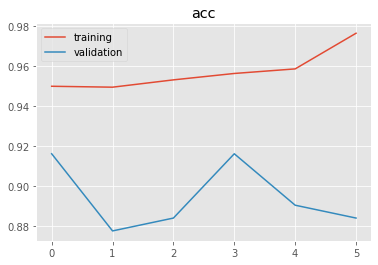

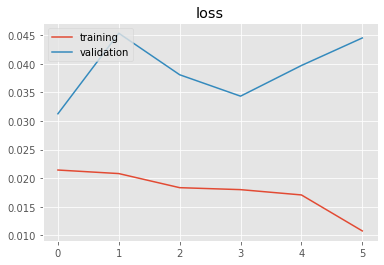

In [ ]:
#acc
history3 = gru.fit(tr_x, tr_y, validation_data = (val_x, val_y), epochs = 100, batch_size = 32, callbacks = [es, mc], verbose = 0)
plt.plot(history3.history['acc'])
plt.plot(history3.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title("acc")
plt.show()

#loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title("loss")
plt.show()

In [ ]:
submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
9338,9339,0
9339,9340,0
9340,9341,0
9341,9342,0


In [ ]:
submission['target'] = np.argmax(cnn_pred, axis = 1)

In [ ]:
submission.head(20)

,id,target
0,1,0
1,2,0
2,3,1
3,4,3
4,5,2
5,6,0
6,7,0
7,8,1
8,9,3
9,10,3


In [ ]:
submission.to_csv('/content/drive/MyDrive/모의, 실전경진대회/[DACON] 손동작 분류 경진대회/data2/scaling_cnn11.csv', index = False)

In [ ]:
submission.target.value_counts()

1    2436
2    2427
3    2278
0    2202
Name: target, dtype: int64

## Voting

* 과반수 원리의 코드를 짜서 직접 Voting을 해보았습니다.

In [ ]:
#scaling cnn(basic_cnn, random_state=42)
df1 = pd.read_csv("/content/drive/MyDrive/모의, 실전경진대회/[DACON] 손동작 분류 경진대회/data2/scaling_cnn5.csv")

#scaling cnn(basic_cnn,random_state=2022)
df2 = pd.read_csv("/content/drive/MyDrive/모의, 실전경진대회/[DACON] 손동작 분류 경진대회/data2/scaling_cnn7.csv")
#LSTM
df3 = pd.read_csv("/content/drive/MyDrive/모의, 실전경진대회/[DACON] 손동작 분류 경진대회/data2/scaling_lstm1.csv")

In [ ]:
def more_than_half(nums):
  set_list = set(nums)
  result, count = 0, 0

  for i in set_list:
    if count < nums.count(i):
      result = i
      count  = nums.count(i)

  return result

answer = []
for i in range(len(df1)):
  nums = [df1['target'][i], df2['target'][i], df3['target'][i]]
  answer.append(more_than_half(nums))

In [ ]:
Id = []
for i in range(len(df1)):
  Id.append(df1["id"][i])

df_mean = pd.DataFrame({'id': Id, 'target': answer})
df_mean

In [ ]:
df_mean.target.value_counts()